In [1]:
from utils import *

############################################################################################################
""" Parameters """

only_407 = False
# set_debug(True)
create_folders_instead = False

basic_plots_and_rmse = False
advanced_plots = False
advanced_plots_only_person = False

verbose_participant = False
verbose_read_csv_files = False
verbose_basic_rmse = False
verbose_compute_turning = False
verbose_plot_turning = False
verbose_plot_main_map_with_turns = False
verbose_plot_all_turns = False


encode_walking_direction_params = {'direction_in_cluster_thres': 1, 'cluster_leak_thres': 1, 'starting_leak_allowance': -5}
compute_basic_turnings_params = {'inter_cluster_is_turn_thres': 50, 'turning_window_size': 12, 'start_end_buffer': 50}
remove_non_desicive_turns_params = {'avg_radius_pre_post_turn_limit': 40, 'ignore_turn_pre_post_avgs_diff_thres': 50}
plot_main_map_with_turns_params = {'black_radius': 2, 'black_mod': 50, 'blue_radius': 2, 'start_thres': 20, 
                                   'turnings': True, 'green_start': False, 'red_end': True, 
                                   'black_marks': False, 'blue_marks': True, 'grey_marks': False}
plot_all_turns_plot_options = {'single_turn_paths': True, 
                               'distance': True, 'speed_difference': True, 'walking_direction_difference': True, 
                               'speeds': True, 'walking_directions': True}
    

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
collect_all_turns = {}
clean_DS_store_files()
# normal_participants_list = [407,408]+[i for i in range(2101,2112) if i != 2110]
normal_participants_list = [2111]

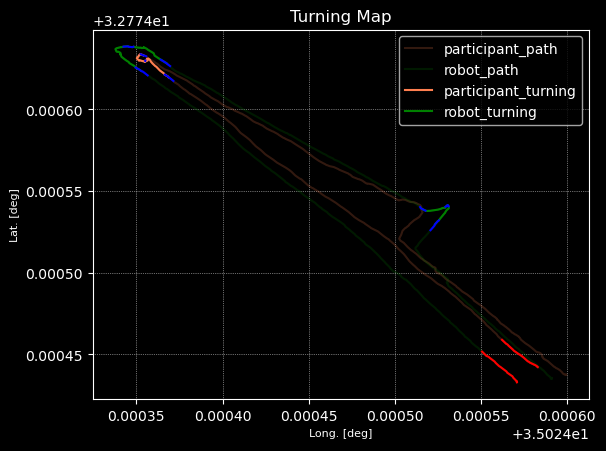

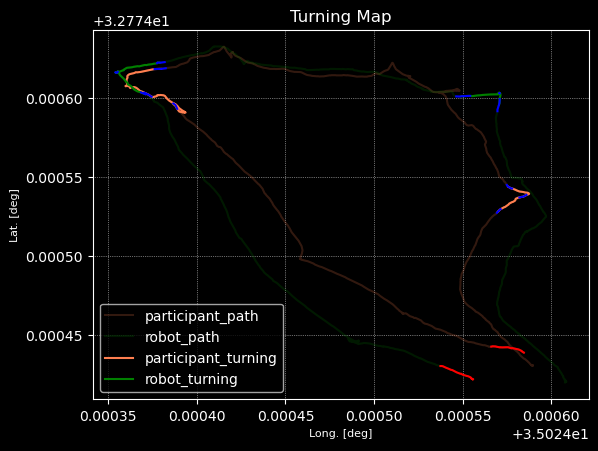

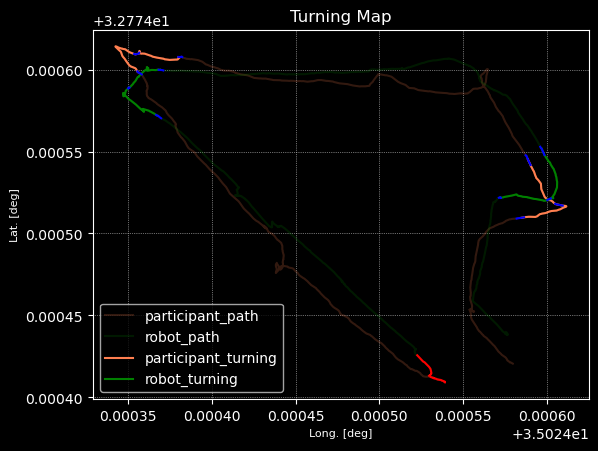

<Figure size 640x480 with 0 Axes>

In [3]:
for participant_id in normal_participants_list:
    collect_all_turns[f"{participant_id}"] = {}
    if verbose_participant:
        print(f'participant {participant_id}')
    
    results_folder, turns_folder = create_base_folders(participant_id, instead=create_folders_instead if participant_id==407 else False)
    
    for path_num in range(0, 3):
        
        parent_dir = f'./data/{participant_id}/'
        df_person, df_robot = read_csv_files(parent_dir, path_num, verbose=verbose_read_csv_files)
        df = preprocess_join(df_person, df_robot)
        df = add_cols(df)
        pre = results_folder + f'{str(participant_id)}_{str(path_num+1)}_'
        
        if basic_plots_and_rmse:
            basic_plots(df, pre)
            rmse_results = basic_rmse(df, pre, verbose=verbose_basic_rmse)

        df = fix_walking_direction(df)

        X = get_clean_walking_direction_np(df, 'walking_direction') 
        X_robot = get_clean_walking_direction_np(df, 'walking_direction_robot')
        
        walking_direction_encoded = encode_walking_direction(X, **encode_walking_direction_params)
        walking_direction_encoded_robot = encode_walking_direction(X_robot, **encode_walking_direction_params)
        
        df['walking_direction_encoded'] = walking_direction_encoded
        df['walking_direction_encoded_robot'] = walking_direction_encoded_robot
        
        if verbose_compute_turning:
            print("Person:")
        is_turning = compute_basic_turnings(df, walking_direction_encoded, 
                                            verbose=verbose_compute_turning, **compute_basic_turnings_params)
        is_turning = remove_non_decisive_turns(df, walking_direction_encoded, is_turning, 
                                               verbose=verbose_compute_turning, **remove_non_desicive_turns_params)
        df['is_turning'] = is_turning
        lmrs = get_lmrs(is_turning, verbose=verbose_compute_turning)
        
        if verbose_compute_turning:
            print("Robot:")
        is_turning_robot = compute_basic_turnings(df, walking_direction_encoded_robot, 
                                                  verbose=verbose_compute_turning, **compute_basic_turnings_params)
        is_turning_robot = remove_non_decisive_turns(df, walking_direction_encoded_robot, is_turning_robot, 
                                                     verbose=verbose_compute_turning, **remove_non_desicive_turns_params)
        df['is_turning_robot'] = is_turning_robot
        lmrs_robot = get_lmrs(is_turning_robot, verbose=verbose_compute_turning)
        
        if advanced_plots:
            plot_advanced(df, pre, advanced_plots_only_person)
            
        et_etr = {407: {0: ([(0, -8, 10)], [(0, 10, -10)]), 1: ([], [(4, 40, 0)]), 2: ([], [(0, 20, 20)])},
                  408: {0: ([], []), 1: ([(0, -20, 20)], [(0, -10, 10), (1, -10, 20)]), 2: ([(0, 10, -10)], [(0, 10, 0)])},
                  2101: {0: ([(1, -70, 40)], [(0, -20, 20)]), 1: ([(0, -20, 20), (1, -20, 20)], [(0, -20, 20), (1, -20, 20)]), 2: ([], [(2, 10, 10)])},
                  2102: {0: ([(0, -5, 5)], [(0, 5, 2)]), 1: ([], []), 2: ([(0, -15, 5), (2, -10, 0), (4, -10, 10), (5, -10, 10)], [(0, 5, 0), (1, -5, 5), (2, -30, 15), (3, -10, 7), (4, -15, 0), (5, -15, 20)])},
                  2103: {0: ([(0, -20, 20)], [(0, -20, 20)]), 1: ([(1, -20, 20), (4, -15, 15)], [(1, -20, 0), (3, -15, 15)]), 2: ([(0, -10, 10), (1, -15, 20)], [(1, -10, 10), (2, -15, 15)])},
                  2104: {0: ([(0, -20, 5)], [(0, -20, 5)]), 1: ([(0, -5, -20)], [(0, -10, -20)]), 2: ([(0, 5, -5)], [(0, 5, -5)])},
                  2105: {0: ([(0, -15, 15)], [(0, -15, 15)]), 1: ([(0, -20, 30), (1, 40, 40), (2, 0, 30)], [(0, -35, -15), (1, -10, 20), (3, -5, 20), (4, 0, 15), (5, -10, 20), (6, 0, 10)]), 2: ([], [(0, -10, 10), (2, -15, 15)])},
                  2106: {0: ([(0, -20, 20)], [(0, -10, 0)]), 1: ([(0, -15, 0)], [(0, -20, 5)]), 2: ([(1, -20, 20), (3, -5, 5), (4, 0, 10), (5, -15, 15), (6, -15, 15), (7, -5, 60)], [(0, -7, 7), (4, -40, 5), (6, 0, 10), (7, 5, 20), (8, -50, 10), (9, -40, 10)])},
                  2107: {0: ([(0, -15, 15)], [(0, -15, 15)]), 1: ([(0, -10, 15), (3, 2, 5)], [(0, -10, 0), (3, 15, -20)]), 2: ([(0, 0, 20), (1, -10, 10), (3, -5, -5), (4, -2, -25)], [(0, -30, 10), (1, -10, 10),  (4, -10, 5)])},
                  2108: {0: ([], [(1, -10, 5)]), 1: ([(0, 0, 30), (1, -30, 10)], [(2, -20, 15), (3, -7, -3), (4, 10, 30)]), 2: ([(0, -60, -5), (1, -10, 10), (2, -10, -5)], [(1, -15, 0), (2, -10, 0)])},
                  2109: {0: ([(0, 5, -5)], [(0, -2, 2)]), 1: ([(2, -2, -2)], [(0, 4, 4), (1, 0, -25), (2, -2, -2)]), 2: ([(1, 51, 2)], [(1, 0, 10), (2, 55, 10)])},
                  2111: {0: ([], []), 1: ([(1, -10, -10)], [(1, -10, 10)]), 2: ([(0, -15, 25), (2, 10, 10)], [(0, 23, 7)])},
                  }
        def extend_turns(df):
            et, etr = et_etr[participant_id][path_num]
            for i in range(len(lmrs[0])):
                for ets in et:
                    if i == ets[0]:
                        is_turning[lmrs[0][i]:lmrs[2][i]] = [0]*(lmrs[2][i]-lmrs[0][i])
                        lmrs[0][i] += ets[1]
                        lmrs[2][i] += ets[2]
                        is_turning[lmrs[0][i]:lmrs[2][i]] = [1]*(lmrs[2][i]-lmrs[0][i])
            for i in range(len(lmrs_robot[0])):
                for etrs in etr:
                    if i == etrs[0]:
                        is_turning_robot[lmrs_robot[0][i]:lmrs_robot[2][i]] = [0]*(lmrs_robot[2][i]-lmrs_robot[0][i])
                        lmrs_robot[0][i] += etrs[1]
                        lmrs_robot[2][i] += etrs[2]
                        is_turning_robot[lmrs_robot[0][i]:lmrs_robot[2][i]] = [1]*(lmrs_robot[2][i]-lmrs_robot[0][i])
            df['is_turning'] = is_turning
            df['is_turning_robot'] = is_turning_robot
            return df
        df = extend_turns(df)
        
        dt_dtr = {407: {0: ([], []), 1: ([], [1]), 2: ([], [])},
                  408: {0: ([0, 1], [0, 1]), 1: ([], []), 2: ([1], [1])},
                  2101: {0: ([0, 2, 3, 4], [1]), 1: ([2], []), 2: ([], [])},
                  2102: {0: ([1, 2], [1, 2]), 1: ([1, 2], [0]), 2: ([1, 3], [])},
                  2103: {0: ([], []), 1: ([0, 2, 3], [0, 2]), 2: ([2, 3, 4, 5], [0, 3, 4])},
                  2104: {0: ([], []), 1: ([], []), 2: ([], [])},
                  2105: {0: ([], []), 1: ([1, 3, 4], [2]), 2: ([], [1])},
                  2106: {0: ([], []), 1: ([1], [1]), 2: ([0, 2], [1, 2, 3])},
                  2107: {0: ([], []), 1: ([1, 2], [1, 2]), 2: ([2], [2])},
                  2108: {0: ([], [0]), 1: ([2, 3], [0, 1]), 2: ([], [0])}, 
                  2109: {0: ([], []), 1: ([], []), 2: ([], [])},
                  2111: {0: ([], []), 1: ([], []), 2: ([1], [])},
                  }
        def drop_turns(df):
            dt, dtr = dt_dtr[participant_id][path_num]
            for i in range(len(lmrs[0])):
                if i in dt:
                    is_turning[lmrs[0][i]:lmrs[2][i]] = [0]*(lmrs[2][i]-lmrs[0][i])
            for i in range(len(lmrs_robot[0])):
                if i in dtr:
                    is_turning_robot[lmrs_robot[0][i]:lmrs_robot[2][i]] = [0]*(lmrs_robot[2][i]-lmrs_robot[0][i])
            
            df['is_turning'] = is_turning
            df['is_turning_robot'] = is_turning_robot
            return df
        df = drop_turns(df)
        lmrs = get_lmrs(is_turning, verbose=verbose_compute_turning)
        lmrs_robot = get_lmrs(is_turning_robot, verbose=verbose_compute_turning)
        
        
        df = discretize_turnings(df)
        
        plot_main_map_with_turns(df, turns_folder + f'{str(participant_id)}_{str(path_num+1)}_', lmrs, lmrs_robot, 
                                 verbose=verbose_plot_main_map_with_turns, **plot_main_map_with_turns_params, savefig=False)
